<div class="alert alert-info"><h3>SARIMAX: Multivariat Time Series Analysis</h3><br>
    <a>Master Thesis: Machine  Learning  basierstes  Forecasting  des  Elektromobilitätshochlaufs  in  Deutschland</a><br>
    <a>Name: Taj Mohammad Ghulam Zada</a><br>
    <a>Hochschule: Technische Hochschule Brandenburg</a><br>
    <a>Semester: 5</a><br>
    <a>Datum: 01. December 2022</a><br>
</div>


**SARIMAX(AR,Integration, MA)(Seasonal AR, Seasonal Integration, Seasonal MA, Length of seasonal cycle) –––> SARIMAX(p,d,q)(P,D,Q)m**

ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an additional set of parameters $(P,D,Q)m$ that specifically describe the seasonal components where:
 * $P$ : Seasonal autoregression
 * $D$ : Seasonal Differencing or Integration
 * $Q$ : Seasonal Moving average coefficients,
 * $m$ : Number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html
https://www.statsmodels.org/stable/statespace.html
https://www.statsmodels.org/stable/api.html#univariate-time-series-analysis
    


# Importing Libraries

In [1]:
import pandas as pd                                                 # For Tabular Datas
import numpy as np                                                  # For Dimensional ND-Array Data
import matplotlib.pyplot as plt                                     # For Visualisation purposes
from pmdarima import auto_arima                                     # For HPO with PMD-ARIMA
import warnings                                                     # Ignore unharmful messages
import seaborn as sns                                               # Achieve better Visualization with Seaborn
from statsmodels.tsa.statespace.sarimax import SARIMAX              # SARIMA model
import itertools                                                    # Iteration modul
from sklearn.metrics import mean_squared_error                      # MSE Error Metrics
import scipy.stats                                                  # For QQ-Plot
from statsmodels.tsa.stattools import adfuller                      # For Augmented Dickey-Fuller Test (Stationarity Test)
from statsmodels.tsa.seasonal import seasonal_decompose             # For Seasonal Decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf       # For ACF, PACF Plots
from statsmodels.graphics.tsaplots import month_plot, quarter_plot  # For Monthly and Quarterly Seasonality Plots
import joblib                                                       # For saving SARIMA-Modell or Optuna Study
import time                                                         # For Time use cases
import optuna                                                       # For Hyperparameter Tuning with Optuna
warnings.filterwarnings("ignore")                                   # Supress Warnings
#sns.set()                                                          # Sets Seaborn as default visualisation library


##### To make Visualisations/Plots in Python bigger:

#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 6
#import cycler
#plt.rcParams['axes.prop_cycle'] = cycler.cycler(color='g')

# Loading dataset

* Varibales: Market-share (%) of BEV-PKW new registration of 33 countries
* Tager values: Market-share (%) of BEV-PKW new registration in Germany
* Index: Datum

In [2]:
# Loading dataset
df1 = pd.read_csv('Path/To/Dataset/01_Multivariate_BEV_PKW_Dataset.csv', index_col='datum')
df1.head()

Austria  Belgium  Bulgaria  Croatia  Cyprus  Czech Republic  \
datum                                                                     
2020-01-01     3.03     1.41      1.15     0.97    0.26            2.01   
2020-02-01     4.66     1.85      1.46     1.03    0.39            1.21   
2020-03-01     7.06     4.44      0.50     1.10    0.27            1.91   
2020-04-01     4.96     2.91      0.24     1.49    0.00            1.85   
2020-05-01     3.64     2.14      0.98     1.56    0.38            0.74   

            Denmark  Estonia  Finland  France  ...  Poland  Portugal  Romania  \
datum                                          ...                              
2020-01-01     2.83     0.48     1.67    8.16  ...    0.52      6.09     1.41   
2020-02-01     3.28     0.77     2.74    5.63  ...    0.52      4.02     0.89   
2020-03-01     7.30     1.42     5.56    8.79  ...    0.64      9.28     0.78   
2020-04-01     3.65     1.21     3.26    5.80  ...    0.81      8.66     1.16   
2020-05-01     3.23     2.26     2.19    4.27  ...    0.90      4.82     0.96   

            Slovakia  Slovenia  Spain  Sweden  Switzerland  Turkey  \
datum                                                                
2020-01-01      0.62      1.93   1.90    7.31         4.10    0.03   
2020-02-01      0.83      3.01   1.71    6.49         4.08    0.13   
2020-03-01      1.18      3.83   2.00   10.88         8.89    0.08   
2020-04-01      1.34      4.33   2.21    5.50         5.62    0.03   
2020-05-01      1.04      1.99   1.11    5.25         4.93    0.04   

            United Kingdom  
datum                       
2020-01-01            2.78  
2020-02-01            3.15  
2020-03-01            4.54  
2020-04-01           31.80  
2020-05-01           11.48  

[5 rows x 33 columns]

# Explorative Data Analysis (EDA)
Creating a checkpoint:

In [3]:
# Creating checkpoint
df = df1.copy()
df.describe()

Austria    Belgium   Bulgaria    Croatia     Cyprus  Czech Republic  \
count  29.000000  29.000000  29.000000  29.000000  29.000000       29.000000   
mean   10.740000   5.702759   1.954138   2.781379   0.843103        1.473793   
std     5.045019   3.145111   1.149682   2.806063   0.757062        0.938439   
min     3.030000   1.410000   0.240000   0.590000   0.000000        0.490000   
25%     6.490000   3.130000   1.150000   1.080000   0.270000        1.000000   
50%    10.880000   4.840000   1.820000   1.880000   0.650000        1.230000   
75%    13.860000   8.250000   2.420000   2.890000   1.470000        1.730000   
max    20.170000  13.710000   5.580000  13.040000   3.300000        5.700000   

         Denmark    Estonia    Finland     France  ...     Poland   Portugal  \
count  29.000000  29.000000  29.000000  29.000000  ...  29.000000  29.000000   
mean   10.817586   2.342069   8.602759   8.828276  ...   1.418966   7.945517   
std     7.064752   1.065938   5.594323   3.116901  ...   0.843273   3.851911   
min     0.710000   0.480000   1.670000   4.270000  ...   0.520000   2.810000   
25%     4.610000   1.470000   3.420000   5.870000  ...   0.810000   5.190000   
50%     9.520000   2.270000   8.120000   8.200000  ...   1.130000   6.920000   
75%    16.900000   2.920000  12.270000  11.660000  ...   1.950000   9.740000   
max    26.810000   5.260000  24.180000  14.650000  ...   3.860000  18.000000   

         Romania   Slovakia   Slovenia      Spain     Sweden  Switzerland  \
count  29.000000  29.000000  29.000000  29.000000  29.000000    29.000000   
mean    4.158621   1.411034   3.506207   2.707931  16.394138    11.185862   
std     4.125133   0.538817   1.763668   1.236072   9.815321     5.177386   
min     0.780000   0.610000   1.340000   0.960000   5.250000     4.080000   
25%     1.450000   1.060000   2.240000   1.870000   6.850000     7.030000   
50%     2.460000   1.270000   3.260000   2.470000  15.090000     9.720000   
75%     5.720000   1.560000   4.330000   4.110000  24.170000    14.200000   
max    17.950000   2.740000  10.140000   5.430000  36.420000    22.820000   

          Turkey  United Kingdom  
count  29.000000       29.000000  
mean    0.366897       11.078966  
std     0.368065        6.614706  
min     0.020000        2.780000  
25%     0.080000        6.650000  
50%     0.200000        9.060000  
75%     0.590000       15.320000  
max     1.290000       31.800000  

[8 rows x 33 columns]

In [4]:
# Checking Data status i.e. Missing Values etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 2020-01-01 to 2022-05-01
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Austria         29 non-null     float64
 1   Belgium         29 non-null     float64
 2   Bulgaria        29 non-null     float64
 3   Croatia         29 non-null     float64
 4   Cyprus          29 non-null     float64
 5   Czech Republic  29 non-null     float64
 6   Denmark         29 non-null     float64
 7   Estonia         29 non-null     float64
 8   Finland         29 non-null     float64
 9   France          29 non-null     float64
 10  Germany         29 non-null     float64
 11  Greece          29 non-null     float64
 12  Hungary         29 non-null     float64
 13  Iceland         29 non-null     float64
 14  Ireland         29 non-null     float64
 15  Italy           29 non-null     float64
 16  Latvia          29 non-null     float64
 17  Liechtenstein   29 non-nu

In [5]:
# Setting the DF frequency to per Month oder 'MS'
df.index = pd.to_datetime(df.index)
df.index.freq = 'MS'
# dataset = dataset.asfreq('MS') # Alternative Method
# Checking index if the changes were applied
df.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01'],
              dtype='datetime64[ns]', name='datum', freq='MS')

In [6]:
# Checking missing values
df.isna().sum()

Austria           0
Belgium           0
Bulgaria          0
Croatia           0
Cyprus            0
Czech Republic    0
Denmark           0
Estonia           0
Finland           0
France            0
Germany           0
Greece            0
Hungary           0
Iceland           0
Ireland           0
Italy             0
Latvia            0
Liechtenstein     0
Lithuania         0
Luxembourg        0
Malta             0
Netherlands       0
Norway            0
Poland            0
Portugal          0
Romania           0
Slovakia          0
Slovenia          0
Spain             0
Sweden            0
Switzerland       0
Turkey            0
United Kingdom    0
dtype: int64

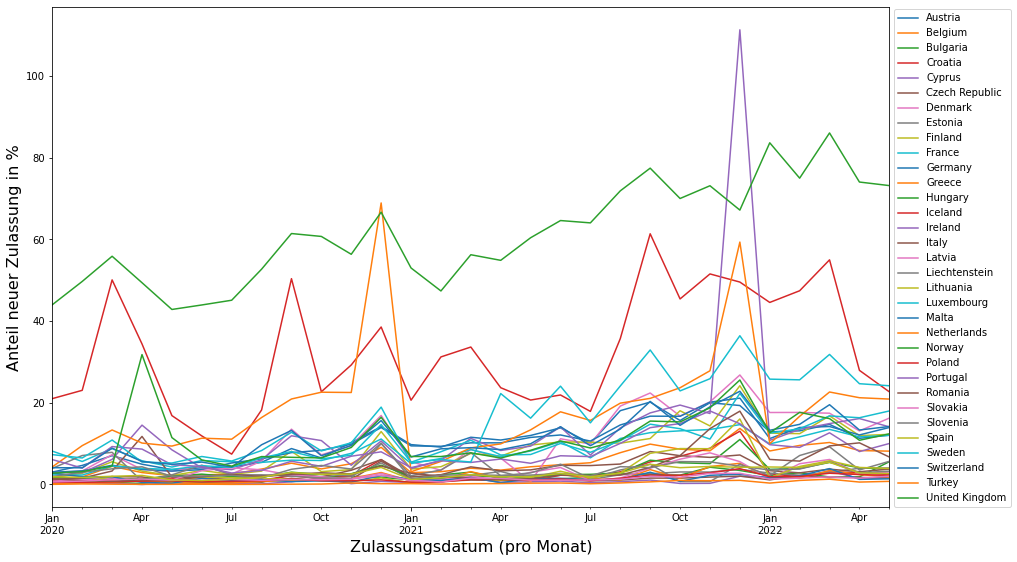

In [7]:
# Visualization of the input data
df.plot(figsize=(15,9.2))
#plt.title('Neu Zulassung BEV-PKWs in 33 Ländern', size=22)
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=3, bbox_to_anchor=(1.0,-0.01))
plt.show()

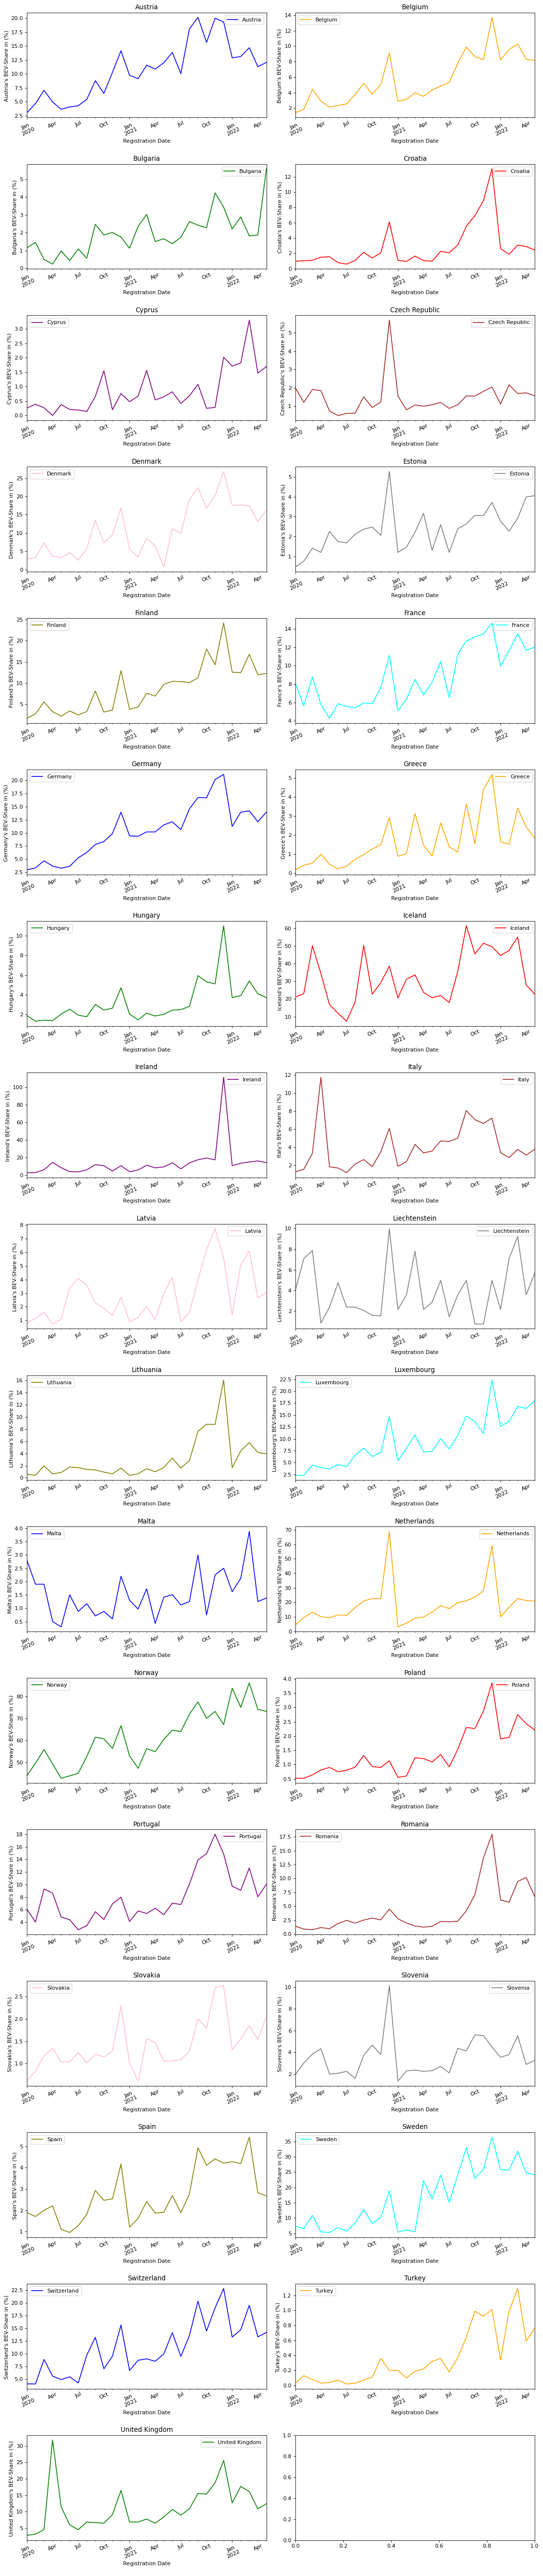

In [8]:
# Visualisation of dataset per variable on a seperate plot.
# Defining type of colors for variables
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

def Visualize(data):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.set_xlabel("Registration Date\n".format(key)), 
        ax.set_ylabel("{}'s BEV-Share in (%) ".format(key)), 
        ax.legend([key])
    plt.tight_layout()


Visualize(df)

## Handling Outlier:

In [9]:
# There is an outlier in Variable "Ireland". Thus, it needs to be handeld.
# Replaces the outlier with: Nov. 2022 + Jan. 2023 (devided by 2)
Irland_Okt_22_Jan2023_Mean = (df["Ireland"]["2021-11-01"] + df["Ireland"]["2022-01-01"])/2
df["Ireland"]["2021-12-01"] = round(Irland_Okt_22_Jan2023_Mean, 2)    

In [10]:
# Deleting any country that has a mean value of less than target variable's lowest values.
# Because Germany's (target value) minimum value is 2.98 (rounded to be 3), therefore,
# Any country that has a mean value lower than 3 is deleted.
# This because those variables won't contribute significantly to accuratle predict the target value.
min_values_germany = 3
country_names_above_required_value = []
for col in df.columns:
    if df[col].mean(axis=0)>min_values_germany:
        country_names_above_required_value.append(col)


country_names_above_required_value

['Austria',
 'Belgium',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Netherlands',
 'Norway',
 'Portugal',
 'Romania',
 'Slovenia',
 'Sweden',
 'Switzerland',
 'United Kingdom']

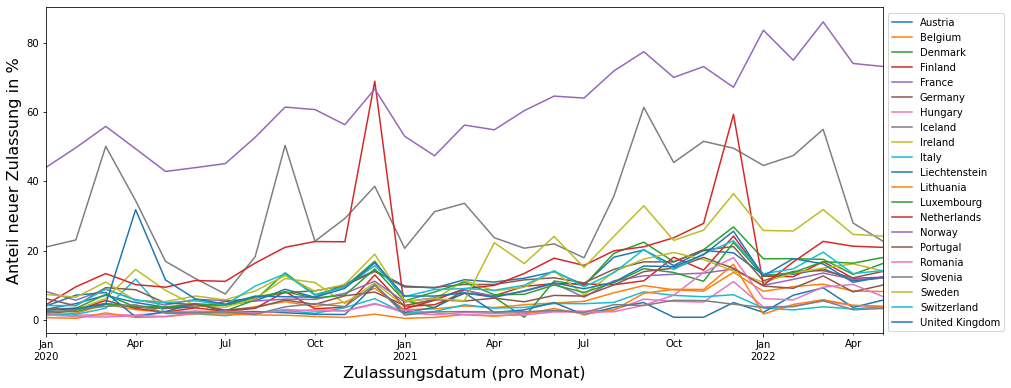

In [11]:
df = df[country_names_above_required_value]
df.plot(figsize=(15,6))
#plt.title('Neu Zulassung BEV-PKWs in 33 Ländern', size=22)
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=3, bbox_to_anchor=(1.0,-0.01))
plt.show()

In [12]:
# Checking the input data again
df.head()

Austria  Belgium  Denmark  Finland  France  Germany  Hungary  \
datum                                                                      
2020-01-01     3.03     1.41     2.83     1.67    8.16     2.98     1.88   
2020-02-01     4.66     1.85     3.28     2.74    5.63     3.34     1.30   
2020-03-01     7.06     4.44     7.30     5.56    8.79     4.69     1.41   
2020-04-01     4.96     2.91     3.65     3.26    5.80     3.69     1.36   
2020-05-01     3.64     2.14     3.23     2.19    4.27     3.28     2.02   

            Iceland  Ireland  Italy  ...  Lithuania  Luxembourg  Netherlands  \
datum                                ...                                       
2020-01-01    21.02     2.88   1.25  ...       0.61        2.36         4.31   
2020-02-01    23.05     2.89   1.55  ...       0.40        2.31         9.51   
2020-03-01    50.09     6.14   3.30  ...       1.97        4.50        13.34   
2020-04-01    34.41    14.53  11.76  ...       0.65        3.94        10.14   
2020-05-01    16.86     8.48   1.82  ...       0.88        3.68         9.40   

            Norway  Portugal  Romania  Slovenia  Sweden  Switzerland  \
datum                                                                  
2020-01-01   44.01      6.09     1.41      1.93    7.31         4.10   
2020-02-01   49.71      4.02     0.89      3.01    6.49         4.08   
2020-03-01   55.88      9.28     0.78      3.83   10.88         8.89   
2020-04-01   49.40      8.66     1.16      4.33    5.50         5.62   
2020-05-01   42.85      4.82     0.96      1.99    5.25         4.93   

            United Kingdom  
datum                       
2020-01-01            2.78  
2020-02-01            3.15  
2020-03-01            4.54  
2020-04-01           31.80  
2020-05-01           11.48  

[5 rows x 21 columns]

In [13]:
df.describe()

Austria    Belgium    Denmark    Finland     France    Germany  \
count  29.000000  29.000000  29.000000  29.000000  29.000000  29.000000   
mean   10.740000   5.702759  10.817586   8.602759   8.828276  10.390000   
std     5.045019   3.145111   7.064752   5.594323   3.116901   5.011553   
min     3.030000   1.410000   0.710000   1.670000   4.270000   2.980000   
25%     6.490000   3.130000   4.610000   3.420000   5.870000   6.280000   
50%    10.880000   4.840000   9.520000   8.120000   8.200000  10.190000   
75%    13.860000   8.250000  16.900000  12.270000  11.660000  13.950000   
max    20.170000  13.710000  26.810000  24.180000  14.650000  21.140000   

         Hungary    Iceland    Ireland      Italy  ...  Lithuania  Luxembourg  \
count  29.000000  29.000000  29.000000  29.000000  ...  29.000000   29.000000   
mean    3.180690  32.235172  10.293793   3.941034  ...   3.029655    9.478966   
std     2.020735  14.443505   4.882091   2.408453  ...   3.475084    5.151469   
min     1.300000   7.430000   2.880000   1.170000  ...   0.390000    2.310000   
25%     1.920000  21.020000   6.050000   2.120000  ...   0.940000    5.440000   
50%     2.480000  29.260000  10.750000   3.380000  ...   1.650000    8.020000   
75%     3.910000  45.430000  14.110000   4.690000  ...   3.920000   13.640000   
max    11.020000  61.380000  19.440000  11.760000  ...  16.040000   22.310000   

       Netherlands     Norway   Portugal    Romania   Slovenia     Sweden  \
count    29.000000  29.000000  29.000000  29.000000  29.000000  29.000000   
mean     18.561379  61.415862   7.945517   4.158621   3.506207  16.394138   
std      14.209325  12.265003   3.851911   4.125133   1.763668   9.815321   
min       3.110000  42.850000   2.810000   0.780000   1.340000   5.250000   
25%       9.970000  52.710000   5.190000   1.450000   2.240000   6.850000   
50%      16.390000  60.730000   6.920000   2.460000   3.260000  15.090000   
75%      21.240000  71.890000   9.740000   5.720000   4.330000  24.170000   
max      68.930000  86.070000  18.000000  17.950000  10.140000  36.420000   

       Switzerland  United Kingdom  
count    29.000000       29.000000  
mean     11.185862       11.078966  
std       5.177386        6.614706  
min       4.080000        2.780000  
25%       7.030000        6.650000  
50%       9.720000        9.060000  
75%      14.200000       15.320000  
max      22.820000       31.800000  

[8 rows x 21 columns]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2020-01-01 to 2022-05-01
Freq: MS
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Austria         29 non-null     float64
 1   Belgium         29 non-null     float64
 2   Denmark         29 non-null     float64
 3   Finland         29 non-null     float64
 4   France          29 non-null     float64
 5   Germany         29 non-null     float64
 6   Hungary         29 non-null     float64
 7   Iceland         29 non-null     float64
 8   Ireland         29 non-null     float64
 9   Italy           29 non-null     float64
 10  Liechtenstein   29 non-null     float64
 11  Lithuania       29 non-null     float64
 12  Luxembourg      29 non-null     float64
 13  Netherlands     29 non-null     float64
 14  Norway          29 non-null     float64
 15  Portugal        29 non-null     float64
 16  Romania         29 non-null     float64
 17  Slovenia

## Correltaion check:

### Spearman’s Rank Correlation
This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. 


The function takes two real-valued samples as arguments and returns both the correlation coefficient in the range between -1 and 1 and the p-value for interpreting the significance of the coefficient.

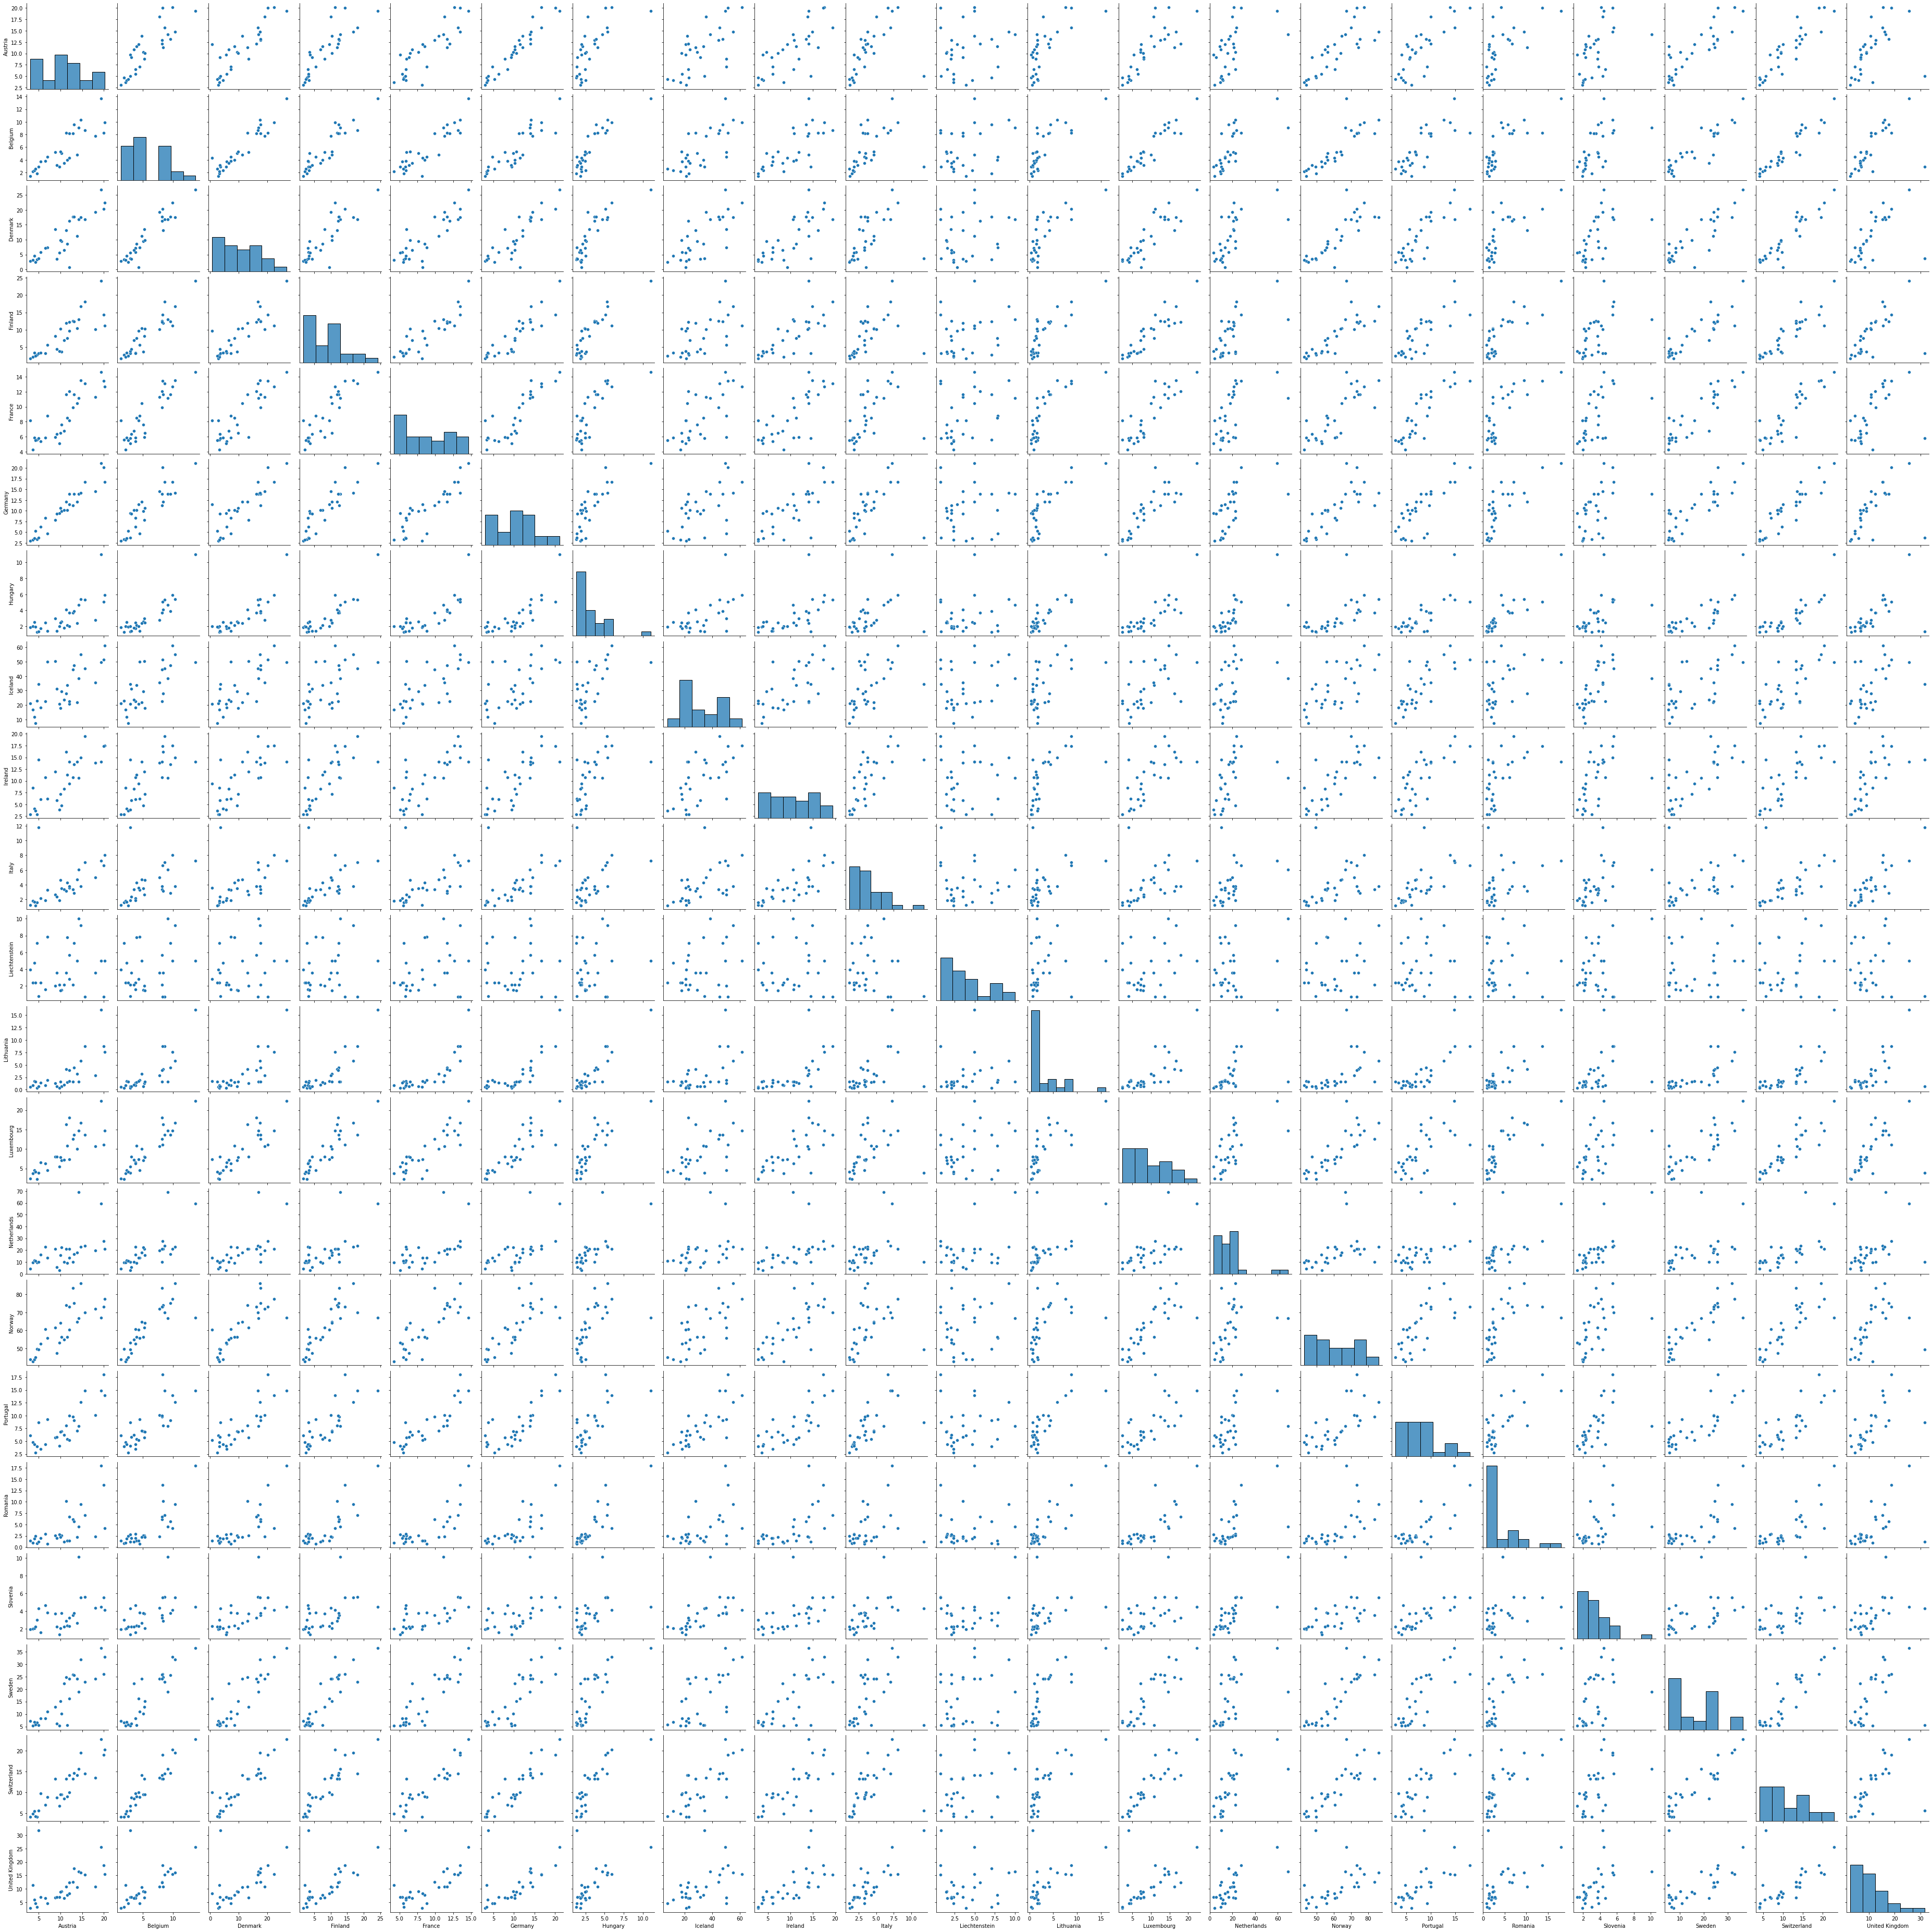

In [15]:
# Visualisation of pairplot
sns.pairplot(df)

In [16]:
# Spearman’s Rank Correlation
df_corr=df.corr(method='spearman')
df_corr

Austria   Belgium   Denmark   Finland    France   Germany  \
Austria         1.000000  0.875862  0.851232  0.902463  0.864252  0.973146   
Belgium         0.875862  1.000000  0.908374  0.923645  0.863760  0.894063   
Denmark         0.851232  0.908374  1.000000  0.846798  0.806356  0.839123   
Finland         0.902463  0.923645  0.846798  1.000000  0.875339  0.911555   
France          0.864252  0.863760  0.806356  0.875339  1.000000  0.867053   
Germany         0.973146  0.894063  0.839123  0.911555  0.867053  1.000000   
Hungary         0.764474  0.867209  0.850209  0.813994  0.772302  0.811114   
Iceland         0.655665  0.713300  0.740887  0.638916  0.691796  0.569845   
Ireland         0.741224  0.751078  0.720532  0.732849  0.729826  0.750154   
Italy           0.783251  0.687685  0.660591  0.701478  0.669869  0.737127   
Liechtenstein   0.149346  0.174772  0.131326  0.165639  0.311976  0.097655   
Lithuania       0.737127  0.780981  0.706578  0.792313  0.829226  0.788073   
Luxembourg      0.866010  0.914778  0.835468  0.921182  0.851441  0.902439   
Netherlands     0.637438  0.789163  0.704926  0.660099  0.655087  0.686869   
Norway          0.854680  0.922660  0.876355  0.870936  0.827297  0.863760   
Portugal        0.788177  0.801478  0.813300  0.794089  0.887164  0.769894   
Romania         0.684236  0.787685  0.756650  0.754187  0.678246  0.770880   
Slovenia        0.633900  0.698694  0.678739  0.600887  0.660917  0.594998   
Sweden          0.829412  0.876709  0.838773  0.851829  0.876925  0.846741   
Switzerland     0.919212  0.954680  0.885714  0.920197  0.865731  0.921656   
United Kingdom  0.709360  0.729557  0.687192  0.711330  0.620103  0.713476   

                 Hungary   Iceland   Ireland     Italy  ...  Lithuania  \
Austria         0.764474  0.655665  0.741224  0.783251  ...   0.737127   
Belgium         0.867209  0.713300  0.751078  0.687685  ...   0.780981   
Denmark         0.850209  0.740887  0.720532  0.660591  ...   0.706578   
Finland         0.813994  0.638916  0.732849  0.701478  ...   0.792313   
France          0.772302  0.691796  0.729826  0.669869  ...   0.829226   
Germany         0.811114  0.569845  0.750154  0.737127  ...   0.788073   
Hungary         1.000000  0.541513  0.680424  0.515398  ...   0.736570   
Iceland         0.541513  1.000000  0.631851  0.574877  ...   0.473762   
Ireland         0.680424  0.631851  1.000000  0.756004  ...   0.717753   
Italy           0.515398  0.574877  0.756004  1.000000  ...   0.536093   
Liechtenstein   0.079259  0.169835 -0.029873 -0.038262  ...   0.233087   
Lithuania       0.736570  0.473762  0.717753  0.536093  ...   1.000000   
Luxembourg      0.844050  0.584236  0.746151  0.630542  ...   0.751663   
Netherlands     0.767430  0.505911  0.630127  0.542857  ...   0.656073   
Norway          0.806110  0.650739  0.756251  0.591133  ...   0.712244   
Portugal        0.680463  0.761576  0.773248  0.775369  ...   0.709781   
Romania         0.877556  0.452709  0.593423  0.376847  ...   0.627248   
Slovenia        0.587482  0.787632  0.659603  0.635132  ...   0.502957   
Sweden          0.770235  0.614608  0.675782  0.563863  ...   0.804608   
Switzerland     0.837398  0.674877  0.771277  0.717734  ...   0.799212   
United Kingdom  0.668391  0.539901  0.773002  0.770443  ...   0.541759   

                Luxembourg  Netherlands    Norway  Portugal   Romania  \
Austria           0.866010     0.637438  0.854680  0.788177  0.684236   
Belgium           0.914778     0.789163  0.922660  0.801478  0.787685   
Denmark           0.835468     0.704926  0.876355  0.813300  0.756650   
Finland           0.921182     0.660099  0.870936  0.794089  0.754187   
France            0.851441     0.655087  0.827297  0.887164  0.678246   
Germany           0.902439     0.686869  0.863760  0.769894  0.770880   
Hungary           0.844050     0.767430  0.806110  0.680463  0.877556   
Iceland           0.584236     0.505911  0.650739  0.761576  0.452709   
Ireland       

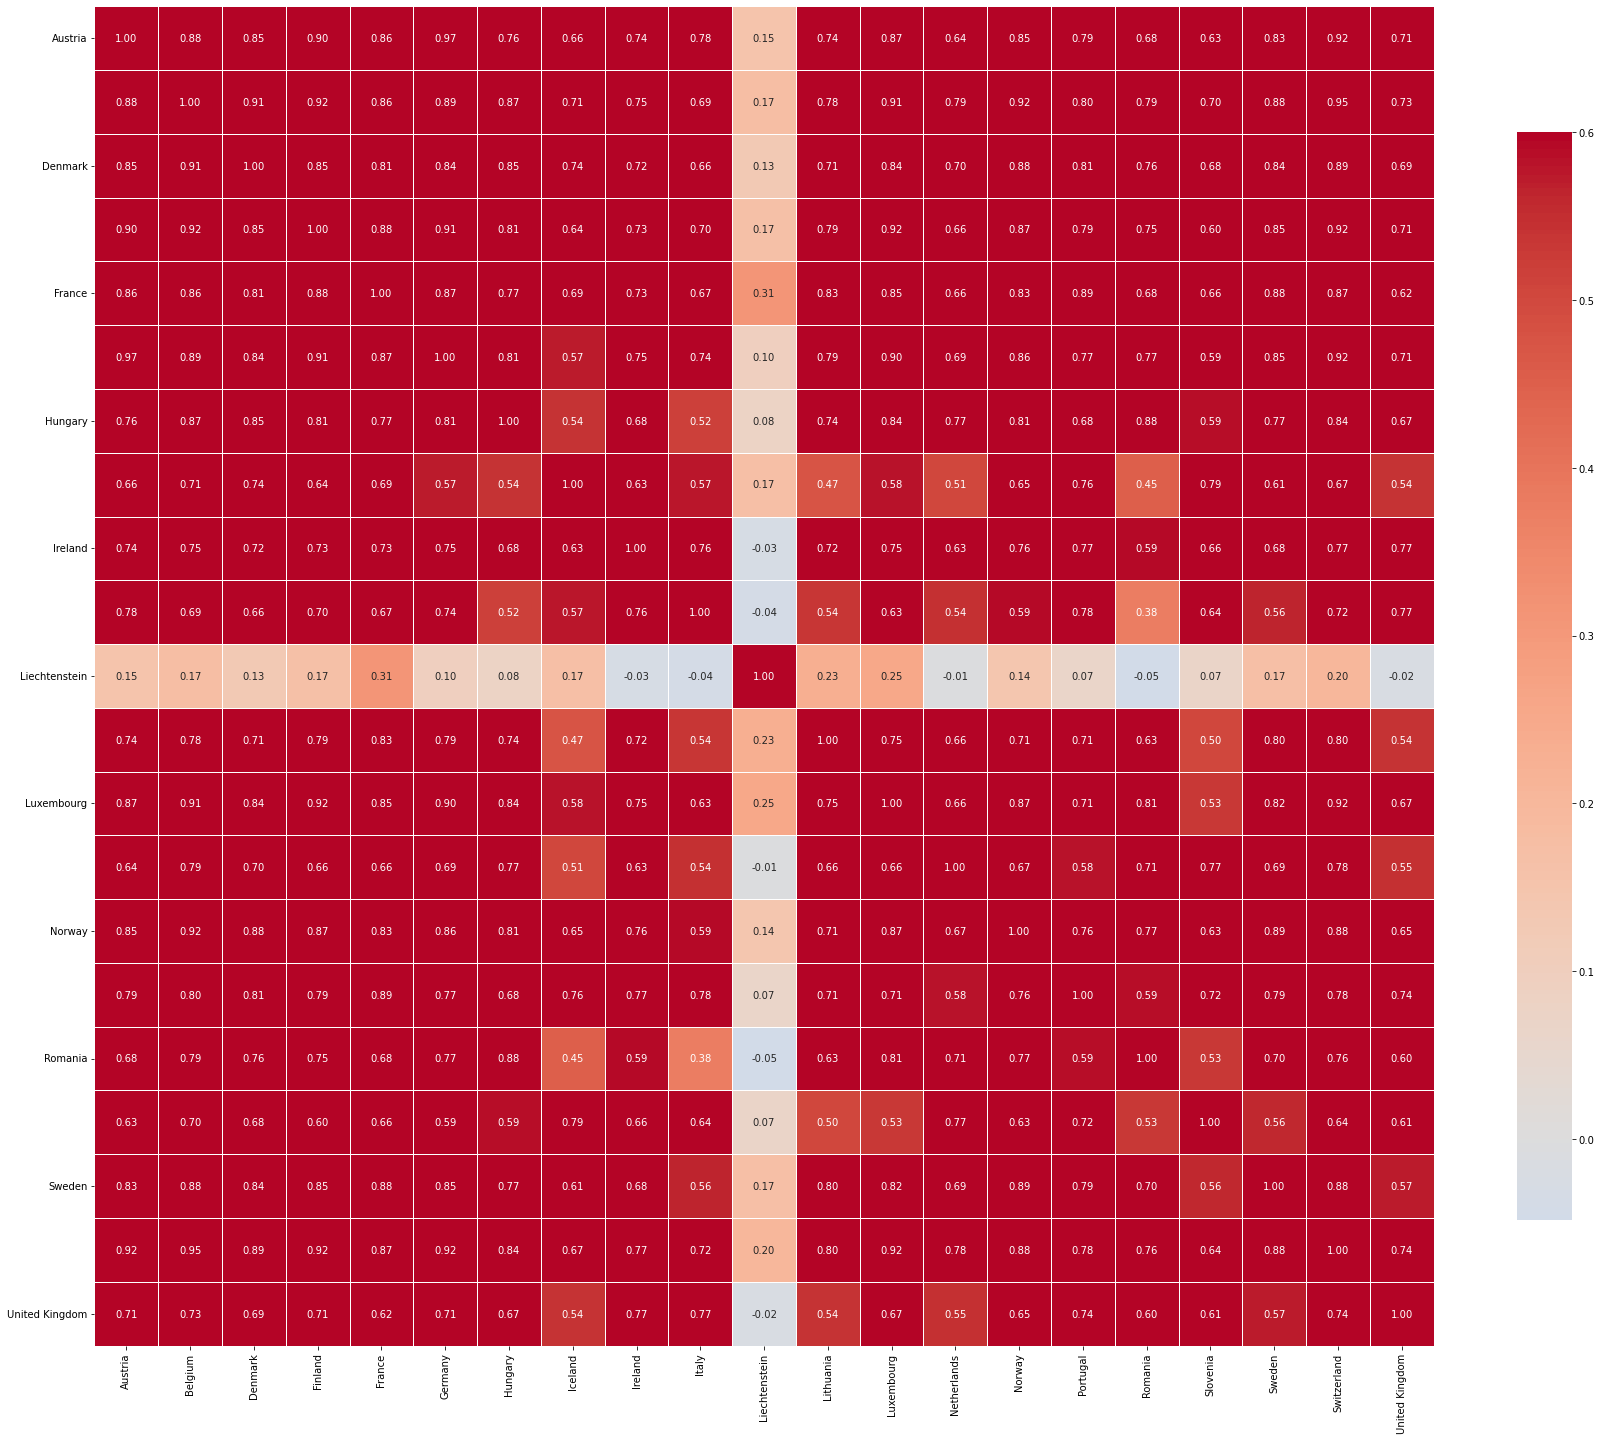

In [17]:
# Visualiziatioin of Spearman's Rank Correlation in a heatmap plot
heat_map = sns.heatmap(df_corr,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')

heat_map.figure.set_size_inches(30,40)
plt.show()

## Stationarity Test
A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests.




### Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

In [15]:
# Testing Stationarity of all Variables with Augmented Dicky-Fuller Test
for i in range(len(df.columns)):
    result = adfuller(df[df.columns[i]])
    if result[1] > 0.05 :
        print('{}: \t\tSeries is not Stationary'.format(df.columns[i]))
    else:
        print('{}:\t\tSeries is Stationary'.format(df.columns[i]))

Austria: 		Series is not Stationary
Belgium: 		Series is not Stationary
Denmark: 		Series is not Stationary
Finland: 		Series is not Stationary
France: 		Series is not Stationary
Germany: 		Series is not Stationary
Hungary:		Series is Stationary
Iceland:		Series is Stationary
Ireland: 		Series is not Stationary
Italy: 		Series is not Stationary
Liechtenstein:		Series is Stationary
Lithuania: 		Series is not Stationary
Luxembourg: 		Series is not Stationary
Netherlands:		Series is Stationary
Norway: 		Series is not Stationary
Portugal: 		Series is not Stationary
Romania: 		Series is not Stationary
Slovenia:		Series is Stationary
Sweden: 		Series is not Stationary
Switzerland: 		Series is not Stationary
United Kingdom:		Series is Stationary


## Seasonal Decomposition
Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the PKW-Allowances).

In [16]:
##### To make Visualisations/Plots in Python bigger:
#* rcParams

from pylab import rcParams      # Importing rcParams
rcParams['figure.figsize'] = 10, 6

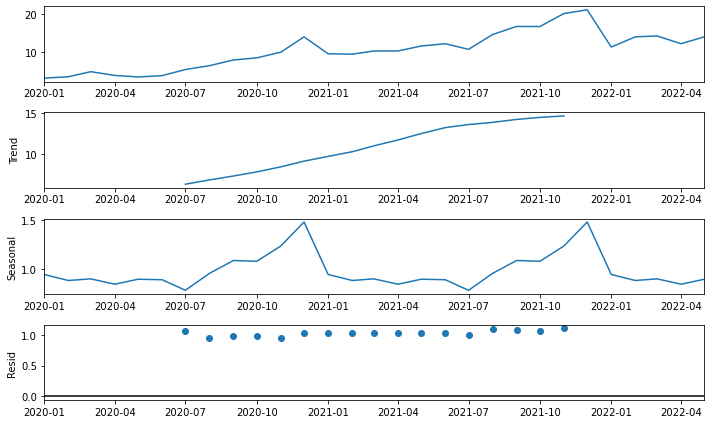

In [17]:
# ETS: Error, Trend, Seasonlity
ETS_seasonal_decomposition = seasonal_decompose(df[['Germany']], model='multiplicative')  # model='add' also works
ETS_seasonal_decomposition.plot();

As Seen above there is :
* upward **Trend**
* **Seasonality**
* **Residual**



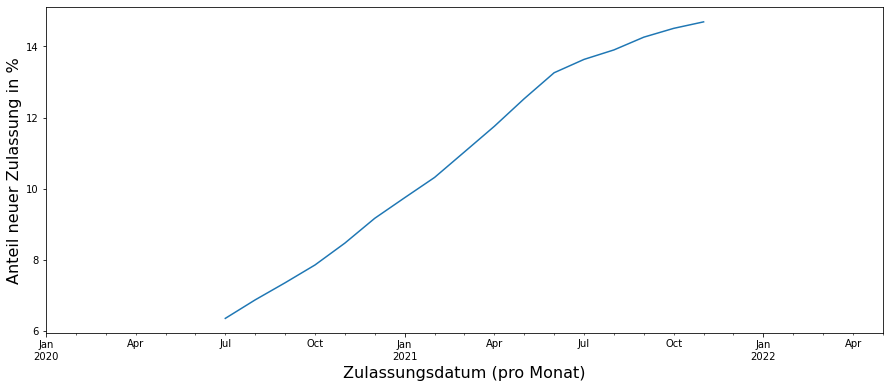

In [18]:
# Histogram of Trend in dataset
# ETS_seasonal_decomposition.resid.plot()
ETS_seasonal_decomposition.trend.plot(figsize=(15,6))
plt.xlabel('Zulassungsdatum (pro Monat)',size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.show()

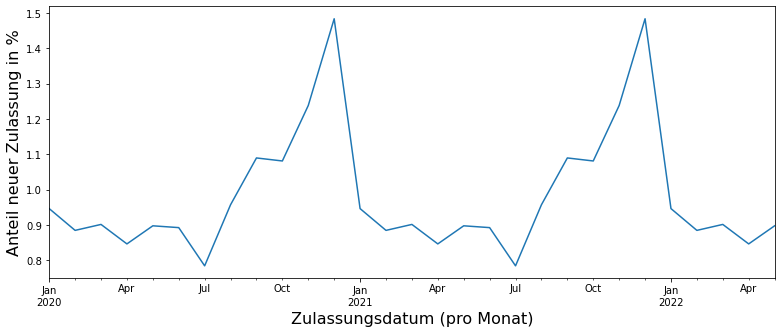

In [19]:
# Histogram of Seasonality in dataset
# ETS_seasonal_decomposition.resid.plot()
ETS_seasonal_decomposition.seasonal.plot(figsize=(13,5))
plt.xlabel('Zulassungsdatum (pro Monat)',size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.show()

In [20]:
# Checking trend values
ETS_seasonal_decomposition.trend.values

array([        nan,         nan,         nan,         nan,         nan,
               nan,  6.36291667,  6.88291667,  7.3625    ,  7.8625    ,
        8.47666667,  9.17375   ,  9.75125   , 10.32041667, 11.0375    ,
       11.75666667, 12.5325    , 13.26083333, 13.63541667, 13.90166667,
       14.26      , 14.5075    , 14.68958333,         nan,         nan,
               nan,         nan,         nan,         nan])

## Exposing Seasonality: Monthly and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter.

**Note:** If the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.

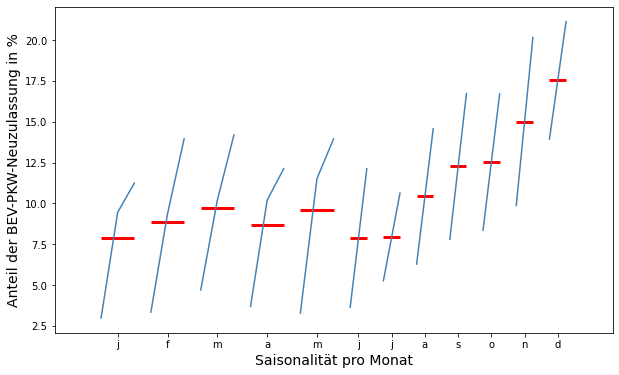

In [21]:

# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df.Germany);

rcParams['figure.figsize'] = 10, 6

for i in range(12):
    plt.gca().get_lines()[i].set_color("steelblue")
plt.xlabel('Saisonalität pro Monat', size=14)
plt.ylabel('Anteil der BEV-PKW-Neuzulassung in %', size=14)
plt.show()

As we can see the months of November and December have higher seasonality and June and July has the lowest seasonality.

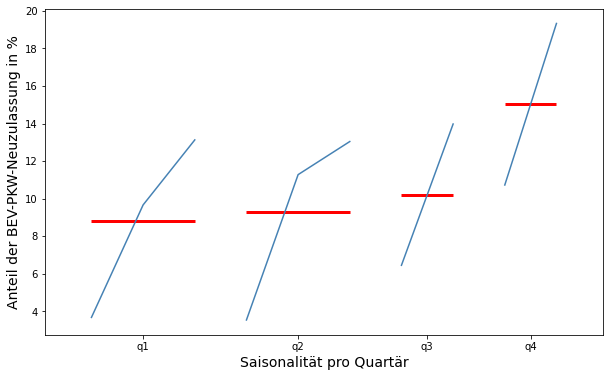

In [22]:
# First: Resamole Data to Quartly
quarter_df = df.Germany.resample(rule='Q').mean()
# Plot Quartly Visualization
quarter_plot(quarter_df);

rcParams['figure.figsize'] = 8, 5

for i in range(4):
    plt.gca().get_lines()[i].set_color("steelblue")
plt.xlabel('Saisonalität pro Quartär', size=14)
plt.ylabel('Anteil der BEV-PKW-Neuzulassung in %', size=14)
plt.show()


Q4 (Oct., Nov. Dec.) has higher seasonality.

# Train Test Split
* Training set:  80%  = 23 Monaten
* Test set:      20% = 6  Monaten

In [23]:
# Setting the training-dataset size (24 Monat)
train_size = int(len(df)*0.80)
# Training and Test set
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

### Overlapping Check

In [24]:
# Tail of Training set
print("Training set: Last rows\n", df_train.tail(3))
print('='*40)
# Head of Test set
print("Test set: First rows\n", df_test.head(3))

Training set: Last rows
             Austria  Belgium  Denmark  Finland  France  Germany  Hungary  \
datum                                                                      
2021-09-01    20.17     9.88    22.40    11.25   12.69    16.72     5.94   
2021-10-01    15.66     8.64    16.75    18.05   13.13    16.70     5.31   
2021-11-01    20.01     8.25    20.23    14.33   13.46    20.15     5.10   

            Iceland  Ireland  Italy  ...  Lithuania  Luxembourg  Netherlands  \
datum                                ...                                       
2021-09-01    61.38    17.52   8.06  ...       7.62       14.76        21.08   
2021-10-01    45.43    19.44   7.05  ...       8.79       13.65        23.68   
2021-11-01    51.55    17.38   6.63  ...       8.75       11.11        27.84   

            Norway  Portugal  Romania  Slovenia  Sweden  Switzerland  \
datum                                                                  
2021-09-01   77.45     13.91     4.19      4.12  

There is no overlapping between train and test sets

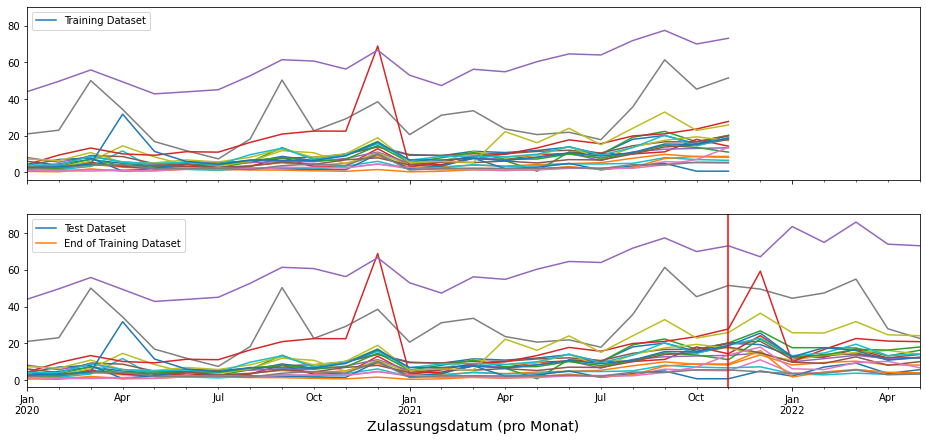

In [25]:
# Visualisation of Train-Test-Split
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16,7))

df_train.plot(ax=ax[0])
ax[0].legend(["Training Dataset"], loc="upper left")

df.plot(ax=ax[1])
ax[1].axvline(df_train.index[-1], color="r")  # End of Training dataset
ax[1].legend(["Test Dataset", "End of Training Dataset"], loc="upper left")
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=14)
plt.show()

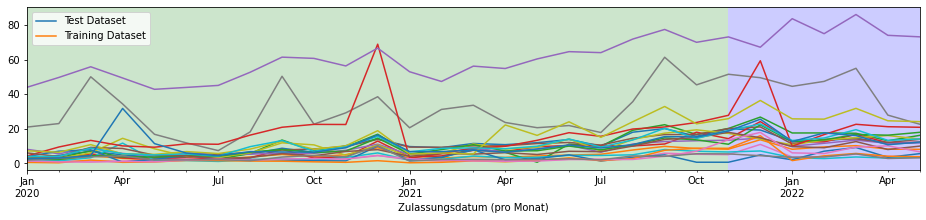

In [26]:
# Visualisation of Train-Test-Split in one Plot
fig, ax = plt.subplots()

df.plot(ax=ax, figsize=(16,3))
#ax.axvline(df_train.index[-1], color="r")  # Create a line between training and test dataset.
ax.legend(["Test Dataset", "Training Dataset"], loc="upper left")
plt.axvspan(df_train.index[0] , df_train.index[-1], facecolor="green", alpha=0.2)
plt.axvspan(df_train.index[-1], df_test.index[-1], facecolor="blue", alpha=0.2)
plt.xlabel('Zulassungsdatum (pro Monat)')
#plt.ylabel('Anteil neuer Zulassung in %')
plt.show()

# SARIMAX Model Training

In [27]:
endog_df_train = df_train.Germany
exog_df_train = df_train[['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Hungary', 
                          'Iceland', 'Ireland', 'Italy', 'Liechtenstein', 'Lithuania', 
                          'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Romania', 
                          'Slovenia', 'Sweden', 'Switzerland', 'United Kingdom']]


endog_df_test = df_test.Germany
exog_df_test = df_test[['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Hungary', 
                        'Iceland', 'Ireland', 'Italy', 'Liechtenstein', 'Lithuania', 
                        'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Romania', 
                        'Slovenia', 'Sweden', 'Switzerland', 'United Kingdom']]

In [28]:
sarimax_model = SARIMAX(endog=endog_df_train,               # Training Dataset
                        exog=exog_df_train,                 # External Variable, aka externel factors
                        order=(4,0,1),                      # p,d,q order
                        seasonal_order= (0,0,3,12),         # P,D,Q order
                        freq='MS',                          # Data Frequency
                        n_jobs=-1                           # Num of CPUs, -1 mean all CPUs
                        )
# Fitting SARIMA Model
results = sarimax_model.fit()
# Outputs Model Summary
print(results.summary());

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.02407D-01    |proj g|=  1.74304D+01

At iterate    5    f= -4.40059D-01    |proj g|=  3.23394D+00

At iterate   10    f= -4.65420D-01    |proj g|=  7.68122D-01

At iterate   15    f= -4.84097D-01    |proj g|=  1.99621D+00

At iterate   20    f= -4.96771D-01    |proj g|=  8.71610D-01

At iterate   25    f= -5.05585D-01    |proj g|=  2.53744D+00

At iterate   30    f= -5.16795D-01    |proj g|=  1.68284D+00

At iterate   35    f= -5.24700D-01    |proj g|=  9.44824D+00

At iterate   40    f= -5.27353D-01    |proj g|=  6.12011D+00

At iterate   45    f= -5.27426D-01    |proj g|=  3.39796D+00

At iterate   50    f= -5.31218D-01    |proj g|=  2.19097D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

# Model Evaluation


In [29]:
# General format to obtain predictions
start_date=len(df_train)
end_date=len(df_train) + len(df_test) -1
pred = results.predict(start=start_date, 
                       end=end_date,
                       exog = exog_df_test,
                       dynamic=False,
                       typ='level').rename('SARIMAX(4,0,1)x(0,0,3) Forecast')

pred

2021-12-01    20.036115
2022-01-01    12.809378
2022-02-01    10.003377
2022-03-01    14.916455
2022-04-01    15.271771
2022-05-01    14.841396
Freq: MS, Name: SARIMAX(4,0,1)x(0,0,3) Forecast, dtype: float64

Passing **<tt>dynamic=False</tt>** means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing **<tt>typ='levels'</tt>** predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

Passing **<tt>rename('SARIMA Predictions')</tt>** creates a name for our predicted varaible. This is helpful when we plot the data and shows up in 'Legend'

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [30]:
# Comparison: observation vs. predicted values
for i in range(len(pred)):
    print(f"predicted = {pred[i]:<11.6} \t expected = {endog_df_test[i]}")

predicted = 20.0361     	 expected = 21.14
predicted = 12.8094     	 expected = 11.24
predicted = 10.0034     	 expected = 13.95
predicted = 14.9165     	 expected = 14.19
predicted = 15.2718     	 expected = 12.13
predicted = 14.8414     	 expected = 13.95


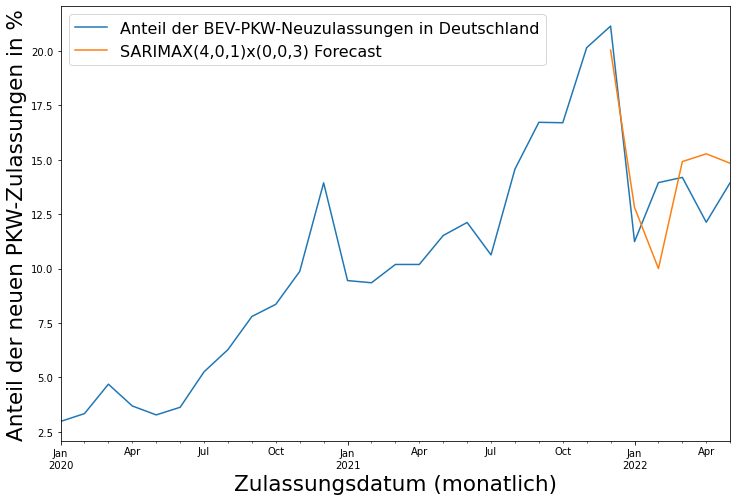

In [31]:
# Visualisation of Test-Dataset vs. Predicted Values.
df[["Germany"]].plot(legend=True)
pred.plot(legend=True, figsize=(12,8))
#plt.title("Forecasting: Test Dataset v.s. Predicted Values\n", size=24)
plt.xlabel("Zulassungsdatum (monatlich)", size=21.5)
plt.ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
plt.legend(["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "SARIMAX(4,0,1)x(0,0,3) Forecast"],fontsize=16)
plt.show()

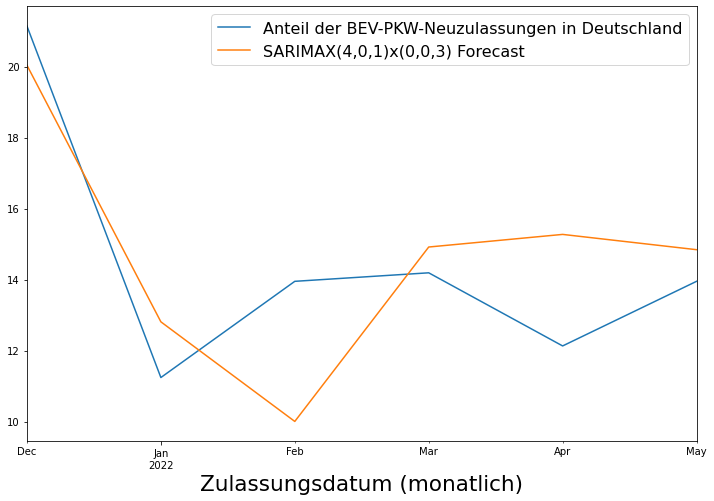

In [32]:
# Visualisation of Test-Dataset vs. Predicted Values.
df[["Germany"]].iloc[-len(pred):].plot(legend=True)
pred.plot(legend=True, figsize=(12,8))
#plt.title("Forecasting: Test Dataset v.s. Predicted Values\n", size=24)
plt.xlabel("Zulassungsdatum (monatlich)", size=21.5)
#plt.ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
plt.legend(["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "SARIMAX(4,0,1)x(0,0,3) Forecast"],fontsize=16)
plt.show()

### RMSE Error

In [33]:
RMSE = np.sqrt(mean_squared_error(endog_df_test, pred))
print(f'RMSE Error  = \t {RMSE:11.4}')

RMSE Error  = 	       2.253


In [34]:
# Checking mean values of Test Dataset v.s. Predicted values:
print("Average value of test-set:  \t", round(endog_df_test.values.mean(), 3))
print("Average value of prediction:\t", round(pred.mean(), 3))

Average value of test-set:  	 14.433
Average value of prediction:	 14.646


# Hyperparameter Optimization (HPO)
## Auto-Arima

In [35]:
auto_arima_deep = auto_arima(y=df.Germany[6:], # Name of target variable we are predicting
                             exogenous=df[[i for i in df.columns if i !='Germany']][6:],   # Variables that represent externel factore i.e. data from other countries
                             seasonal=True,
                             m = 12,           # Seasonal cycle length
                             max_order = 200,  # Maximum amount of variables to be used in the regression (p + q). "None" allows model be more flexible and to choose any combination.
                             max_p = 10,        # Maximum AR components (Highest non-seasonal AR order)
                             max_q = 10,        # Maximum MA components
                             max_d = 10,        # Maximum Integrations
                             max_P = 10,        # Maximum Seasonal AR components
                             max_Q = 10,        # Maximum Seasonal MA components
                             max_D = 10,        # Maximum Seasonal Integrations
                             start_p = 0,      # Minimum AR components (Highest non-seasonal AR order)
                             start_q = 0,      # Minimum MA components
                             start_P = 0,      # Minimum Seasonal AR components
                             start_Q = 0,      # Minimum Seasonal MA components
                             maxiter = 100,    # Maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
                             alpha = 0.05,     # Level of significance, default is 5%, which we should be using most of the time
                             n_jobs = -1,      # How many models to fit at a time (-1 indicates "as many as possible")
                             information_criterion = 'aic', # 'aic', 'aicc', 'bic', 'hqic', 'oob'
                             out_of_sample_size = int(len(df)*0.20),    # validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)
                             )

print(auto_arima_deep.summary())               # To show model summary

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   23
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood              -17543.046
Date:                            Thu, 10 Nov 2022   AIC                          35134.092
Time:                                    15:57:02   BIC                          35161.344
Sample:                                         0   HQIC                         35140.946
                                             - 23                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.305e-05      0.035     -0.001      0.999      -0.070       0.070
x1             0.6102      0.001   

## Grid Search

In [ ]:
# Keep record of grid search time
start_time = time.time()

# Define the p, d and q parameters to take any value between 0 and 4 (exclusive)
p = d = q = range(0, 5)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Note: here is 12 in the 's' position as we have monthly data
PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Define function
def sarimax_gridsearch(pdq, PDQs, endog=endog_df_train, exog=exog_df_train, freq='MS', maxiter=100):
    '''
    Input:
        df_train : your time series data
        pdq : ARIMA combinations from above
        PDQs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. e.g. 'D' for day, 'H' for hour, 'Y' for year.
    Return:
        Prints out the parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal PDQs parameters and get the best AIC value
    results = []
    for pdq_comb in pdq:
        for PDQs_combs in PDQs:
            try:
                sarimax_model=SARIMAX(endog=endog_df_train,  # This is the target variable in dataset
                                exog=exog_df_train,          # This is the external variables dataset
                                order=pdq_comb,
                                seasonal_order=PDQs_combs,
                                freq=freq)
                result=sarimax_model.fit(disp=False, maxiter=maxiter)
                pred=result.predict(start=len(df_train), 
                                    end=(len(df_train) + len(df_test) -1), 
                                    exog = exog_df_test,
                                    dynamic=False,
                                    typ='level').rename(f'SARIMAX {pdq_comb}x{PDQs_combs}: Predictions')

                RMSE = np.sqrt(mean_squared_error(endog_df_test, pred))
                results.append([pdq_comb, PDQs_combs, round(result.aic, 5), round(RMSE, 5)])
                print(f'\n{len(results)}  of  15625 Models \t SARIMAX {pdq_comb}x{PDQs_combs} \t AIC Criterion: {round(result.aic, 5)} \t RMSE: {round(RMSE, 5)}')
            except:
                pass

    # Convert the results into dataframe
    results_df = pd.DataFrame(results, columns=['pdq', 'seasonal_PDQs', 'AIC_Error', 'RMSE'])
    # Sort the DataFrame according to RMSE
    results_df = results_df.sort_values(by=['RMSE'],ascending=True)
    # Returning grid search result as a DataFrame
    return results_df

# Executing grid search function
gridsearch = sarimax_gridsearch(pdq, PDQs, endog=df_train.Germany, freq='MS')
# Saving grid search result as CSV-File
gridsearch.to_csv('Path/To/Dataset/01_SARIMAX_gridsearch_RMSE_6MonthsForecast_16525_Models_ParamsMax4_V2.csv')

# Keep record of grid search time
print(f"\nTime spent for grid search with SARIMAX (Minutes):\t{round((time.time() - start_time)/60, 2)}")


1  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 0, 0, 12) 	 AIC Criterion: 25.78041 	 RMSE: 2.31521

2  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 0, 1, 12) 	 AIC Criterion: 27.7746 	 RMSE: 2.31496

3  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 0, 2, 12) 	 AIC Criterion: 28.0827 	 RMSE: 2.56166

4  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 0, 3, 12) 	 AIC Criterion: 31.77892 	 RMSE: 2.31418

5  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 0, 4, 12) 	 AIC Criterion: 32.16694 	 RMSE: 2.57584

6  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 1, 0, 12) 	 AIC Criterion: -121.37259 	 RMSE: 3.19656

7  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 1, 1, 12) 	 AIC Criterion: -119.37283 	 RMSE: 3.19656

8  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 1, 2, 12) 	 AIC Criterion: -117.37233 	 RMSE: 3.19656

9  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 1, 3, 12) 	 AIC Criterion: -115.37259 	 RMSE: 3.19656

10  of  15625 Models 	 SARIMAX (0, 0, 0)x(0, 1, 4, 12) 	 AIC Criterion: -113.37283 	 RMSE: 3.19656

11  of  15625 Models

In [37]:
# Load back the saved Grid Search result:
#gridsearch_loadback=pd.read_csv('Path/To/Dataset/01_SARIMAX_gridsearch_RMSE_6MonthsForecast_16525_Models_ParamsMax4_V2.csv')
#gridsearch_loadback.head()

## Optuna HPO
Optuna has 2 parts:

   * **Objective function:** To define which params and how the model should be trained as well as based on which error metric should Optuna optimize all process.
   * **Trail:** To specify how many times optuna should run to find the best parameter-combination for DeepAR Model.

In [ ]:
# Optuna's Objective Function:

class SarimaxTuningObjective:
    def __init__(self, endog_df_train, exog_df_train, endog_df_test, exog_df_test, freq='MS'):
        """
        df_train: Training Dataset
        df_test: Test Dataset
        freq: Data Frequency
        maxiter: Max. num of iteration
        """

        self.df_train = endog_df_train
        self.df_test = endog_df_test
        self.freq = freq
        #self.maxiter = maxiter

    """
    get_params() Function: Sets types and size of all parameters for HPO process with Optuna:
         trial.suggest_int():           Used for params that take integers values.
         trial.suggest_float():         Used for params that take float values.
         trial.suggest_categorical()    Used for params that take categorical values.
    """
    def get_params(self, trial) -> dict:
        return {
            "p": trial.suggest_int("p", 0, 4),
            "d": trial.suggest_int("d", 0, 4),
            "q": trial.suggest_int("q", 0, 4),
            "P": trial.suggest_int("P", 0, 4),
            "D": trial.suggest_int("D", 0, 4),
            "Q": trial.suggest_int("Q", 0, 4),
        }

    """
    __call__() Function:
        Takes all the specified params,
        Uses training and test datsets,
        trains SARIMA Model,
        then return the RMSE Error accordingly
    """
    def __call__(self, trial):
        params = self.get_params(trial)
        try:
            sarimax_model = SARIMAX(
                endog_df_train,  
                exog=exog_df_train,
                order=(params["p"],params["d"],params["q"]),
                seasonal_order=(params["P"],params["D"],params["Q"],12),
                freq=self.freq)
            result = sarimax_model.fit(disp=False)
            pred = result.predict(start=len(self.df_train), end=(len(self.df_train) + len(self.df_test) -1), exog=exog_df_test)
            RMSE = np.sqrt(mean_squared_error(self.df_test, pred))
            # Returns RMSE metric
            return RMSE
        except:
            pass

Optuna's Execution for HPO:

In [60]:
#optuna.logging.set_verbosity(optuna.logging.WARNING)                                # It basically supresses the level of verbosity.

start_time = time.time()                                                            # Keep record of time HPO takes

from optuna.samplers import TPESampler
sampler = TPESampler(seed=7)   # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler, study_name='SARIMAX Model (Multivariate Time Series Analysis)',      # Name for current Optuna HPO
                            direction="minimize"                                    # Purpose of Param-Tuning -> to minimize the Model-Error
                            )
study.optimize(
    SarimaxTuningObjective(endog_df_train, exog_df_train, endog_df_test, exog_df_test, freq='MS'),
                           n_trials=100)           # Num of Trails to search for

# Outputs num of Trails finished
print(f"Number of finished trials:\t{len(study.trials)}")
# Shows best trail value
trial = study.best_trial
print(f"\nBest trial's Value:\t\t{trial.value}")
# Shows params used for best trials
print("\nParams: ")
for key, value in trial.params.items():
    print(f" {key}:\t{value}")
# Shows time spent for current Optuna HPO Proces (in minutes)
print(f"\nTime spent for for HPO with Optuna (Minutes):\t{round((time.time() - start_time)/60, 2)}")

[I 2022-10-21 22:37:47,941] A new study created in memory with name: Sarimax_HPO_Study_Multivariate_TSA_ParamsMax4
[I 2022-10-21 22:37:48,399] Trial 0 finished with value: 5.081641998181214 and parameters: {'p': 1, 'd': 4, 'q': 3, 'P': 1, 'D': 0, 'Q': 1}. Best is trial 0 with value: 5.081641998181214.
[I 2022-10-21 22:37:49,571] Trial 1 finished with value: 3.197432737262044 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 3, 'D': 1, 'Q': 4}. Best is trial 1 with value: 3.197432737262044.
[I 2022-10-21 22:37:50,769] Trial 2 finished with value: 2.3034669112566073 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 3}. Best is trial 2 with value: 2.3034669112566073.
[I 2022-10-21 22:37:50,959] Trial 3 finished with value: 13.179176026854257 and parameters: {'p': 2, 'd': 2, 'q': 1, 'P': 4, 'D': 2, 'Q': 3}. Best is trial 2 with value: 2.3034669112566073.
[I 2022-10-21 22:37:51,059] Trial 4 finished with value: 7.685104916711605 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 0, 'D': 

Number of finished trials:	100

Best trial's Value:		2.273720368361959

Params: 
 p:	4
 d:	0
 q:	1
 P:	1
 D:	0
 Q:	2

Time spent for for HPO with Optuna (Minutes):	4.47


#### Saving Optuna HPO Study

In [ ]:
# Saving Optuna HPO Study
joblib.dump(study, "Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl.pkl")

# To Load Optuna Study
#study = joblib.load("Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl")
#print(f"Number of finished trials:\t{len(study.trials)}")
#trial = study.best_trial
#print(f"\nBest trial's Value:\t\t{trial.value}")
#print("\nParams: ")
#for key, value in trial.params.items():
#    print(f" {key}:\t{value}")

Optuna provides nice visualisation for each study. To visualise each of these functionalites, we need import Optuna based Plotting Methods:

In [47]:
# Returns Optuna's Tuning results as a DataFrame
optuna_result = study.trials_dataframe()
optuna_result

number      value             datetime_start          datetime_complete  \
0        0   5.081642 2022-10-21 22:37:47.944847 2022-10-21 22:37:48.398887   
1        1   3.197433 2022-10-21 22:37:48.399746 2022-10-21 22:37:49.570891   
2        2   2.303467 2022-10-21 22:37:49.571877 2022-10-21 22:37:50.769048   
3        3  13.179176 2022-10-21 22:37:50.769901 2022-10-21 22:37:50.959444   
4        4   7.685105 2022-10-21 22:37:50.960318 2022-10-21 22:37:51.059563   
..     ...        ...                        ...                        ...   
95      95        NaN 2022-10-21 22:42:00.894935 2022-10-21 22:42:03.985147   
96      96        NaN 2022-10-21 22:42:03.985890 2022-10-21 22:42:07.068540   
97      97        NaN 2022-10-21 22:42:07.069368 2022-10-21 22:42:10.141428   
98      98        NaN 2022-10-21 22:42:10.142131 2022-10-21 22:42:13.217757   
99      99        NaN 2022-10-21 22:42:13.218477 2022-10-21 22:42:16.317547   

                 duration  params_D  params_P  params_Q  params_d  params_p  \
0  0 days 00:00:00.454040         0         1         1         4         1   
1  0 days 00:00:01.171145         1         3         4         0         0   
2  0 days 00:00:01.197171         0         0         3         0         0   
3  0 days 00:00:00.189543         2         4         3         2         2   
4  0 days 00:00:00.099245         4         0         1         0         0   
..                    ...       ...       ...       ...       ...       ...   
95 0 days 00:00:03.090212         2         3         0         1         3   
96 0 days 00:00:03.082650         3         3         0         1         3   
97 0 days 00:00:03.072060         3         3         0         1         3   
98 0 days 00:00:03.075626         3         3         0         1         3   
99 0 days 00:00:03.099070         3         3         0         1         3   

    params_q     state  
0          3  COMPLETE  
1          1  COMPLETE  
2          1  COMPLETE  
3          1  COMPLETE  
4          2  COMPLETE  
..       ...       ...  
95         0      FAIL  
96         0      FAIL  
97         0      FAIL  
98         0      FAIL  
99         0      FAIL  

[100 rows x 12 columns]

In [48]:
# Sorting Optuna's results according to its values 
# This allows us to see all the lowest errors first
optuna_result = optuna_result.sort_values(by='value', ascending=True)
optuna_result.head()

number     value             datetime_start          datetime_complete  \
9        9  2.273720 2022-10-21 22:38:00.261184 2022-10-21 22:38:01.256664   
2        2  2.303467 2022-10-21 22:37:49.571877 2022-10-21 22:37:50.769048   
10      10  2.332232 2022-10-21 22:38:01.257716 2022-10-21 22:38:01.762539   
32      32  2.354370 2022-10-21 22:38:58.800619 2022-10-21 22:38:59.690176   
6        6  2.357357 2022-10-21 22:37:51.358348 2022-10-21 22:37:57.198208   

                 duration  params_D  params_P  params_Q  params_d  params_p  \
9  0 days 00:00:00.995480         0         1         2         0         4   
2  0 days 00:00:01.197171         0         0         3         0         0   
10 0 days 00:00:00.504823         0         0         1         0         1   
32 0 days 00:00:00.889557         0         1         2         0         0   
6  0 days 00:00:05.839860         1         0         2         2         1   

    params_q     state  
9          1  COMPLETE  
2          1  COMPLETE  
10         3  COMPLETE  
32         2  COMPLETE  
6          3  COMPLETE

In [43]:
# Visualising the optimizsation history. It shows how (Optuna's) Error decreased over time.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_optimization_history.html#optuna.visualization.plot_optimization_history
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [44]:
# Visualize parameter importances
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_param_importances.html#optuna.visualization.plot_param_importances
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [49]:
# Check which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [50]:
# Visualize high-dimensional parameter relationships.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_parallel_coordinate.html#optuna.visualization.plot_parallel_coordinate
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [51]:
# Select specific parameters to visualize.
plot_parallel_coordinate(study, params=["p", "Q"])

In [52]:
# Visualize hyperparameter relationships
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_contour.html#optuna.visualization.plot_contour
from optuna.visualization import plot_contour
plot_contour(study)

In [53]:
# Visualize specific hyperparameter relationships
plot_contour(study, params=["d", "D"])

In [54]:
# Visualize individual hyperparameters as slice plot.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_slice.html#optuna.visualization.plot_slice
from optuna.visualization import plot_slice
plot_slice(study)

In [55]:
# Select specific parameters to visualize as slice plot.
plot_slice(study, params=["p", "D"])

In [ ]:
# Visualize empirical distribution function.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_edf.html#optuna.visualization.plot_edf
from optuna.visualization import plot_edf
study_sarima = joblib.load("Path/To/Dataset/01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")
study_sarima.study_name='SARIMA Model'
study_sarimax = joblib.load("Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl")
study_sarimax.study_name='SARIMAX Model'
study_deepAR_univariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V1.pkl")
study_deepAR_univariate_tsa.study_name='DeepAR Model (Univariate)'
study_deepAR_multivariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")
study_deepAR_multivariate_tsa.study_name='DeepAR Model (Multivariate)'

plot_edf([study_sarima, study_sarimax, study_deepAR_univariate_tsa, study_deepAR_multivariate_tsa])

# Forecasting
### Re-Train on full Dataset


In [14]:
# Retrain the model on the full data then forecast the future
sarimax_model = SARIMAX(endog=df.Germany,
                        exog=df[[i for i in df.columns if i !='Germany']],   # Variables that represent externel factore i.e. data from other countries
                        order=(4,0,1),                                       # p,d,q order
                        seasonal_order= (0,0,3,12),                          # P,D,Q order
                        freq='MS',
                        )

results = sarimax_model.fit()
print(results.summary());

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88020D-01    |proj g|=  4.07508D+00

At iterate    5    f=  6.38851D-01    |proj g|=  6.88816D+00

At iterate   10    f=  6.15344D-01    |proj g|=  4.13043D+00

At iterate   15    f=  5.92298D-01    |proj g|=  6.52173D-01

At iterate   20    f=  5.84387D-01    |proj g|=  1.29073D+00

At iterate   25    f=  5.59879D-01    |proj g|=  2.55124D+00

At iterate   30    f=  5.51273D-01    |proj g|=  2.98767D+00

At iterate   35    f=  5.01140D-01    |proj g|=  2.17249D+00

At iterate   40    f=  4.66432D-01    |proj g|=  1.35169D+00

At iterate   45    f=  4.41782D-01    |proj g|=  1.25452D+00

At iterate   50    f=  3.94811D-01    |proj g|=  7.37539D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

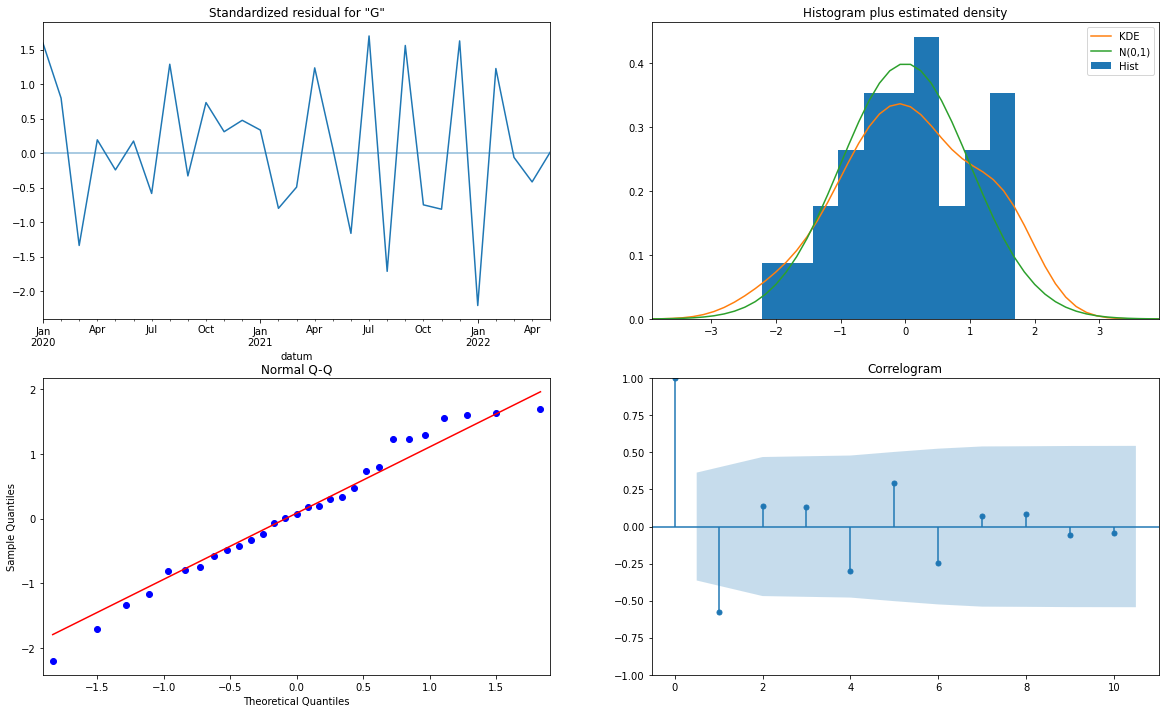

In [15]:
# Model Diagnostics
results.plot_diagnostics(figsize=(20, 12))
plt.show()

## Creating Exogenous Variables for Forecasting 
* Using ETS-Decomposition
* Then multiply seasonalitie of 20 coutries with past 6 values of current exogenous variable

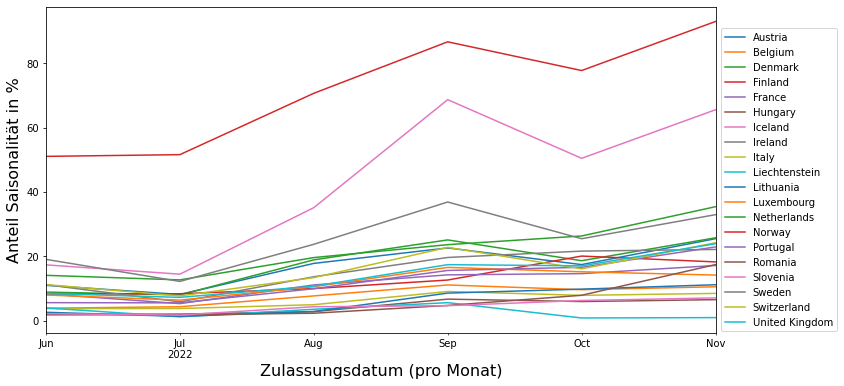

In [26]:
# checkpoint
df_multivariate = df
# Creating an emtpy DataFrame with date range
df_country_seasonality=pd.DataFrame(index=pd.date_range(start="2022-06-01", periods=6, freq="MS"))
df_country_seasonality.index.name = "date"
# Looping through each column to get ONLY their seasonality
ETS_seasonal_decomposition = seasonal_decompose(df_multivariate["Germany"], model='multiplicative', extrapolate_trend='freq')
df_country_seasonality["Germany"] = ETS_seasonal_decomposition.seasonal.iloc[-12:-6].values


df_past_6months = df.iloc[-12:-6]
all_countries_exceot_germany_2 = df_past_6months[[i for i in df.columns if i !='Germany']]
all_countries_exceot_germany_2.index= pd.date_range(start="2022-06-01", periods=6, freq="MS")

new_exog = all_countries_exceot_germany_2 * df_country_seasonality.values
new_exog.plot(figsize=(12,6))
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil Saisonalität in %', size=16)
plt.legend(loc=3, bbox_to_anchor=(1.0,-0.01))
plt.show()

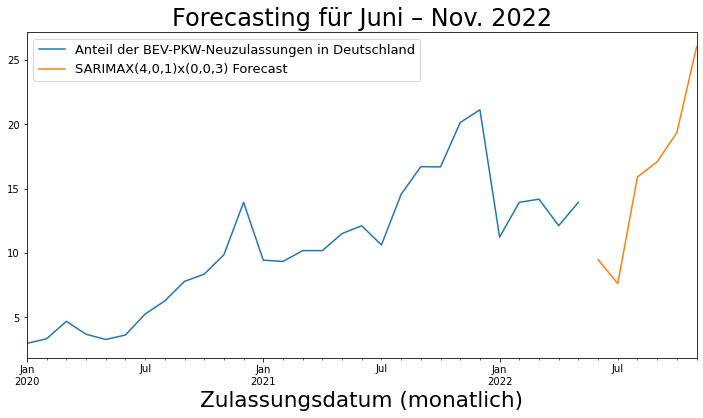

In [27]:
# Make predictions over 6 months
forecast = results.predict(start=len(df), end=len(df)+5, exog=new_exog)

# Plot the results
df.Germany.plot(legend=False)
forecast.plot(legend=True,figsize=(12,6))
plt.title("Forecasting für Juni – Nov. 2022", size=24)
plt.xlabel("Zulassungsdatum (monatlich)", size=21.5)
#plt.ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
plt.legend(["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "SARIMAX(4,0,1)x(0,0,3) Forecast"],fontsize=13, loc="upper left")
plt.show()

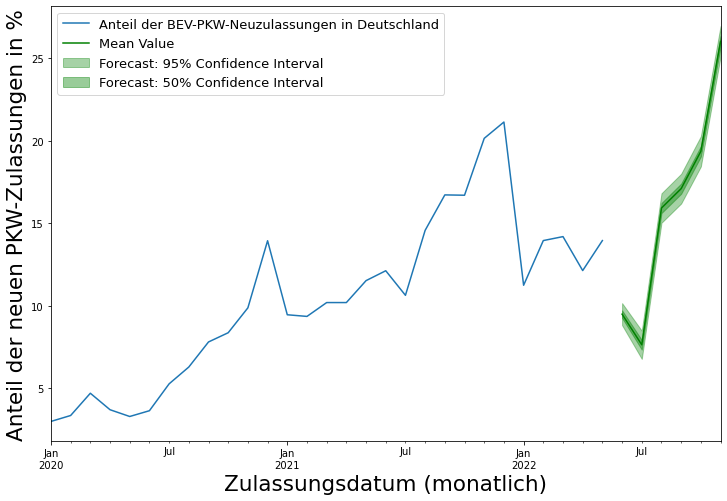

In [28]:
# Confidence Interval Visualization
forecast = results.get_prediction(start=len(df), end=len(df) + 5, exog=new_exog)
#SARIMAXResults.conf_int, can change alpha,the default alpha = 0.05 returns a 95% confidence interval.
pred_ci_95 = forecast.conf_int(alpha=0.05)
#pred_ci_80 = forecast.conf_int(alpha=0.20)
pred_ci_50 = forecast.conf_int(alpha=0.50)

ax = df.Germany.plot(legend=True)
#     print(forecast.predicted_mean)
forecast.predicted_mean.plot(
    ax=ax, 
    #label='Prognose auf 6 Monaten',
    #title="Forecasting: 12 Monaten\n", 
    #alpha=0.5,
    c='green',
    figsize=(12, 8)
    )

ax.fill_between(pred_ci_95.index,
                pred_ci_95.iloc[:, 0],
                pred_ci_95.iloc[:, 1], color='green', alpha=.35)

#ax.fill_between(pred_ci_80.index,
#                pred_ci_80.iloc[:, 0],
#                pred_ci_80.iloc[:, 1], color='green', alpha=.40)#

ax.fill_between(pred_ci_50.index,
                pred_ci_50.iloc[:, 0],
                pred_ci_50.iloc[:, 1], color='green', alpha=.40) 

ax.set_xlabel("Zulassungsdatum (monatlich)", size=21.5)
ax.set_ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
ax.legend(["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Mean Value", "Forecast: 95% Confidence Interval", "Forecast: 50% Confidence Interval"], loc="upper left", fontsize=13)
plt.show()

In [29]:
# Produce the forcasted tables with confidence interval of 95% and 50%
# Get the mean values of the forecasts
pred_mean = forecast.predicted_mean.reset_index()
pred_mean.columns = ['Date','Predicted_Mean']
# Get the 95% confidence interval
pred_mean_CI_95 = pred_ci_95.reset_index()
pred_mean_CI_95.columns = ['Date','Lower Bound 95%_CI','Upper Bound 95%_CI']
# Join 95% confidence interval to the dataframe
prediction_germany_6Months = pred_mean.join(pred_mean_CI_95.set_index('Date'), on='Date')
# get the 50% confidence interval
pred_mean_CI_50 = pred_ci_50.reset_index()
pred_mean_CI_50.columns = ['Date','Lower Bound 50%_CI','Upper Bound 50%_CI']
# Join the 50% confidence interval to the dataframe
prediction_germany_6Months = prediction_germany_6Months.join(pred_mean_CI_50.set_index('Date'), on='Date')
# checking the dataframe
prediction_germany_6Months

Date  Predicted_Mean  Lower Bound 95%_CI  Upper Bound 95%_CI  \
0 2022-06-01        9.486473            8.816660           10.156286   
1 2022-07-01        7.627698            6.771975            8.483421   
2 2022-08-01       15.923063           15.029714           16.816413   
3 2022-09-01       17.100321           16.198092           18.002549   
4 2022-10-01       19.363077           18.444350           20.281804   
5 2022-11-01       26.032687           25.106306           26.959067   

   Lower Bound 50%_CI  Upper Bound 50%_CI  
0            9.255968            9.716979  
1            7.333215            7.922181  
2           15.615632           16.230495  
3           16.789833           17.410808  
4           19.046912           19.679242  
5           25.713888           26.351485

In [30]:
# Saving the forecast as CSV-File
prediction_germany_6Months.to_csv("Path/To/Dataset/Prediction_germany_6Months_SARIMAX_Model.csv")

# Saving trained SARIMAX Model

In [31]:
# Saving the trained SARIMAX model
results.save('Path/To/Dataset/01_SARIMAX/03_Saved_SARIMAX_Models/model.pkl')


# Loading back the trained SARIMAX Model
#from statsmodels.tsa.arima_model import ARIMAResults
#loaded_model = ARIMAResults.load('Path/To/Dataset/01_SARIMA/03_Saved_SARIMAX_Models/model.pkl')


<div class="alert alert-info"><h3>Conclusion</h3>
SARIMAX Model is suitable for a dataset with seasonality and mulitvariability features, but: 

We must also provide exognous vairable when forecasting. This is the requirement of SARIMAX Model. As result we need to have real exogenous variables added to achieve realistic results. Unfortunately we don't have enough data for that.<br>
    
**P.S.: As an alternative following attempts were test:**

* Attempts to use the median value of DeepAR-Model prediction didn't help much.
* Attempts to use the seasonal value of ETS-Decomposition, as recommended by literatures, didn't help either.
</div>